# New Raster Mask

Created 2019-01-15
This program takes the code from Raster Mask and cleans it up for use to do two things:

1. Create new rasters with a simple mask applied
2. Complete connected components of two masks

Check crs of raster
'EPSG:4326' ... or EPSG: 54009

In [15]:
import rasterio
from rasterio.mask import mask
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import matplotlib.pyplot as plt

### Inputs

In [2]:
temp_data = '../../temp_data/'
raster_interim = '../../data/interim/'
raster_raw = '../../data/'

### Functions

In [3]:
# Let's try to make the mask directy with rasterio

def raster_mask_poly(raster, band, density, crs):
    """Fucntion makes numpy array for of raster then applies mask.
    requires rasterio object, band number, and density as float on int and crs of raster
    returns dict of polygons and numpy mask
    """

    mask = raster.read(band)
    mask[mask < density] = 0 # mask as zeros 
    mask[mask >= density] = 1 
    
    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(mask, transform=raster.transform):
        
        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326) removed 2019-01-15
        geom = rasterio.warp.transform_geom(raster.crs, crs, geom, precision=6) # WGS84 (EPSG 4326)
    
    # turn geom into Polygon object from shapely    
    # Polygon(geom['coordinates'][0])
    poly_gdf = gpd.GeoDataFrame()
    for i, poly in enumerate(geom['coordinates']):
        poly_gdf.loc[i,'geometry']= Polygon(poly)

    return mask, geom, poly_gdf

In [4]:
def raster_mask(raster, band, density):
    "Function returns raster mask"
    
    mask = raster.read(band)
    mask[mask < density] = 0 # mask as zeros and ones
    mask[mask >= density] = 1
    
    return mask

In [5]:
# Let's try to make polygons

def raster_poly(raster, band, crs):
    """Fucntion makes ploygons for of raster returns dict of polygons"""

    mask = raster.read(band)
    
    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(mask, transform=raster.transform):
        
        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(raster.crs, crs, geom, precision=6) # WGS84 (EPSG 4326)
    
    # turn geom into Polygon object from shapely    
    # Polygon(geom['coordinates'][0])
    poly_gdf = gpd.GeoDataFrame()
    for i, poly in enumerate(geom['coordinates']):
        poly_gdf.loc[i,'geometry']= Polygon(poly)

    return poly_gdf

In [6]:
# By Ryan Avery 

import numpy as np
import scipy.ndimage as ndimage

def remove_isolated_pixels(mask1, mask2, struct=np.ones((3,3))):
    """
    Unions two binary numpy arrays of the same shape.
    Takes this unioned array and removes solitary pixels.
    Struct should be a binary 3x3 numpy array to define
    connectivity rule. Binary mask arrays should be the 
    shape.
    """
    union_arr = np.logical_or(mask1, mask2)*1
    id_regions, num_ids = ndimage.label(union_arr, structure=struct)
    id_sizes = np.array(ndimage.sum(union_arr, id_regions, range(num_ids + 1)))
    area_mask = (id_sizes == 1)
    union_arr[area_mask[id_regions]] = 0
    return union_arr

### Polygons for >1500 ppl per km2

In [19]:
file = 'GHS_POP_GPW42015_GLOBE_R2015A_54009_1k_v1_0_Clip.tif'
raster = rasterio.open(raster_raw+file)
crs = raster.crs

In [ ]:
# mask1500m, geom1500, poly_gdf1500 = raster_mask_poly(raster, 1, 1500, crs)

In [20]:
maskGHS2015 = raster_mask(raster, 1, 1500)

In [21]:
maskGHS2015.shape

(8716, 8623)

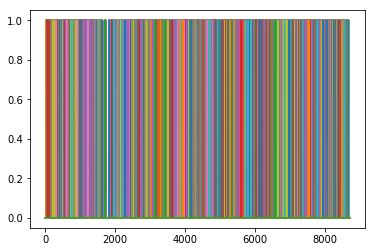

In [22]:
plt.plot(maskGHS2015)
plt.show()

In [ ]:
print(poly_gdf1500.head(6))
print(len(poly_gdf1500))

In [ ]:
# drop first row, which is bounding box of Africa and the write 
poly_gdf1500 = poly_gdf1500.drop(poly_gdf1500.index[0], axis = 0)
poly_gdf1500.head(6)

In [ ]:
# write out polygons 

poly_gdf1500.to_file(temp_data+'GHS_POP_GPW42000_GLOBE_R2015A_54009_1k_v1_0_Clip_1500.shp', driver='ESRI Shapefile')

### Connected Pixels 1500 - 300

In [ ]:
# By Ryan Avery 

import numpy as np
import scipy.ndimage as ndimage

def remove_isolated_pixels(mask1, mask2, struct=np.ones((3,3))):
    """
    Unions two binary numpy arrays of the same shape.
    Takes this unioned array and removes solitary pixels.
    Struct should be a binary 3x3 numpy array to define
    connectivity rule. Binary mask arrays should be the 
    shape.
    """
    union_arr = np.logical_or(mask1, mask2)*1
    id_regions, num_ids = ndimage.label(union_arr, structure=struct)
    id_sizes = np.array(ndimage.sum(union_arr, id_regions, range(num_ids + 1)))
    area_mask = (id_sizes == 1)
    union_arr[area_mask[id_regions]] = 0
    return union_arr

In [ ]:
# Let's try to make polygons

def raster_poly(raster, band, crs):
    """Fucntion makes ploygons for of raster returns dict of polygons"""

    mask = raster.read(band)
    
    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(mask, transform=raster.transform):
        
        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(raster.crs, crs, geom, precision=6) # WGS84 (EPSG 4326)
    
    # turn geom into Polygon object from shapely    
    # Polygon(geom['coordinates'][0])
    poly_gdf = gpd.GeoDataFrame()
    for i, poly in enumerate(geom['coordinates']):
        poly_gdf.loc[i,'geometry']= Polygon(poly)

    return poly_gdf

In [ ]:
file = rasterio.open(raster_raw+'XXX')
crs = file.crs

In [ ]:
mask300 = raster_mask(file, 1, 300)
mask1500 = raster_mask(file, 1, 1500)

In [ ]:
mask1000c600 = raster_funcs.remove_isolated_pixels(mask1500, mask300)

In [ ]:
poly_gdf_1000c600 = raster_poly(mask1000c600, 1, crs)
print((poly_gdf_1000c600.head(6)))
print(len(poly_gdf_1000c600))

In [ ]:
# drop first row, which is bounding box of Africa
poly_gdf_1000c600_drop = test_poly.drop(test_poly.index[0], axis = 0)
print((poly_gdf_1000c600_drop.head(6)))
print(len(poly_gdf_1000c600_drop))

In [ ]:
# poly_gdf_1000c600_drop.to_file(temp_data+'.shp', driver='ESRI Shapefile')